# <center> Exercise 4 Multilayer Perceptron Implementation </center>

</br>
On this exercise, you are implementing a feedforward neural network from scratch to do the MNIST problem. This one is using <code>Numpy</code>. As an exercise for Backpropagation as you learned from the lecture, you should work through the derivation of the loss function to the weights or biases with pen and paper. 
</br>

We will try to modularize our neural network as it consists of $L$ layers. **Read the following description carefully, otherwise you would have problems implementing it later**. Each layer $l$ has a weight matrix $W^{(l)}$ with the size of $(n^{(l)}, n^{(l-1)})$ where $n^{(l)}$ is the number of neurons (outputs) of the layer $l$, a bias vector $b^{(l)}$ with the size of $(n^{(l)}, 1)$. Each layer $l$ has an activation function $f$. Each layer $l$ can be the last layer or not (the error term is calculated differently in that case). First, we will implement those parts for one layer:
    
* Initialize a layer: Use Xavier Initialization if the activation is sigmoid or tanh, otherwise use He Initialization. (This is already given in the code)
* Do the forward pass through the layer based on its activation function:
    *  $$ z^{(l)} = W^{(l)}\cdot a^{(l-1)} + b^{(l)} $$
        $$ a^{(l)} = f(z^{(l)}) $$
    *  Where:<br/>
        $z^{(l)}$: intermediate net output of layer $l$<br/>
        $a^{(l)}$: activation of layer $l$, is the input of the next layer $l+1$, $a^{(0)} = X$<br/>
* Do the backward pass through the layer. Using the convenient notation $\check{w} = \frac{\partial \mathcal{L}}{\partial w}$ (in the code, $\check{w}$ is denoted by dw):<br/>
$$\check{w}^{(l)} = \check{a}^{(l)} \frac{\partial a^{(l)}}{\partial z^{(l)}}\frac{\partial z^{(l)}}{\partial w^{(l)}}= \check{a}^{(l)}f^{(l)'}a^{(l-1)}$$
* Update the weights/biases based on the gradient descent principle.

Then training the network is divided into several steps:
* Initialize the whole network (by initilizing every layer)
* Split training data into minibatches.
* Iteratively do following steps in $E$ epochs:
    * Shuffle minibatches.
    * Do the forward pass.
    * Calculate the loss.
    * Do the backward pass.
    * Update weights.
    
With the trained model, perform inference steps on the test data.  
  

The implementation uses mini-batches, i.e. multiple input samples are aggregated into one tensor and passed through the forward and backward pass all at once. This means, if a single data sample is a vector $x \in R^n$, then the vectorized implementation has to work on inputs $x \in R^{n \times m}$, where $m$ is the batch size (in this exercise, we put the batch dimension at the end of the tensor). Thanks to `numpy`, such vectorized code often looks 
the same or very similar to the non-vectorized version.

First, let's import `numpy` and explore some basic methods: 

In [1]:
import numpy as np


# 2. Implement basic activation functions (vectorized version)

__Sigmoid__:

In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

__Hyperbolic Tangent__:

In [3]:
def tanh(z):
    return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)

__Rectified Linear Unit (ReLU)__:

In [4]:
def relu(z):
    return np.maximum(0, z)

__Linear__:

In [5]:
def linear(z):
    return z

__Softmax__:

In [6]:
def softmax(z):
    ez = np.exp(z - np.max(z))
    return ez / np.sum(ez)
    # The original formula is less preferred due to numerical instability:
    #ez = np.exp(z)
    #return ez / np.sum(ez) 

The code below is also correct, but suffers from overflows in case the values in z get large. (Try x * 1000 instead of x * 100)

In [7]:
def softmax_unstable(z):
    ez = np.exp(z)
    return ez / np.sum(ez)


np.random.seed(42)
x = np.random.rand(4)
print(x)
print(softmax(x))
print(softmax_unstable(x))
print()

x = x * 100
print(x)
print(softmax(x))
print(softmax_unstable(x))

[0.37454012 0.95071431 0.73199394 0.59865848]
[0.18314609 0.3258569  0.26184113 0.22915589]
[0.18314609 0.3258569  0.26184113 0.22915589]

[37.45401188 95.07143064 73.19939418 59.86584842]
[9.48577835e-26 1.00000000e+00 3.17026275e-10 5.13345677e-16]
[9.48577835e-26 1.00000000e+00 3.17026275e-10 5.13345677e-16]


__Softmax for batch__:
</br>

Note that if we do minibatch update, we must compute the softmax along some dimension that is not the batch dimension. From our convention, batch dimension is the second (axis=1), so we must compute the softmax along the first dimension (axis=0).

In [8]:
def softmax_batch(z, axis=0):
    ez = np.exp(z - np.max(z, axis=axis, keepdims=True))
    return ez / np.sum(ez, axis=axis, keepdims=True)
    # The original formula is less preferred due to numerical instability:
    #ez = np.exp(z)
    #return ez / np.sum(ez, axis=axis, keepdims=True)
    

__Test your implementations__:

In [9]:
np.random.seed(1234)
z = np.random.randn(100,2)

sigmoid_z = sigmoid(z)
tanh_z = tanh(z)
my_tanh_z = np.tanh(z)
relu_z = relu(z)
linear_z = linear(z)
softmax_z = softmax(z)


print("Sigmoid results of z[0]=%f, z[6]=%f, z[8]=%f, z[22]=%f, z[98]=%f" \
      %(sigmoid_z[0,0], sigmoid_z[6,0], sigmoid_z[8,0], sigmoid_z[22,0], sigmoid_z[98,0]))
print("Tanh results of z[3]=%f, z[9]=%f, z[18]=%f, z[34]=%f, z[99]=%f" \
      %(tanh_z[3,0], tanh_z[9,0], tanh_z[18,0], tanh_z[34,0], tanh_z[99,0]))
print("Relu results of z[8]=%f, z[16]=%f, z[38]=%f, z[72]=%f, z[88]=%f" \
      %(relu_z[8,0], relu_z[16,0], relu_z[38,0], relu_z[72,0], relu_z[88,0]))
print("Linear results of z[2]=%f, z[6]=%f, z[8]=%f, z[22]=%f, z[98]=%f" \
      %(linear_z[2,0], linear_z[6,0], linear_z[8,0], linear_z[22,0], linear_z[98,0]))
print("Softmax results of z[2]=%f, z[6]=%f, z[8]=%f, z[22]=%f, z[98]=%f" \
      %(softmax_z[2,0], softmax_z[6,0], softmax_z[8,0], softmax_z[22,0], softmax_z[98,0]))

Sigmoid results of z[0]=0.615723, z[6]=0.721783, z[8]=0.599997, z[22]=0.561633, z[98]=0.459803
Tanh results of z[3]=0.696046, z[9]=0.867072, z[18]=0.124070, z[34]=0.208769, z[99]=0.280640
Relu results of z[8]=0.405453, z[16]=1.047579, z[38]=0.226963, z[72]=1.176812, z[88]=2.123692
Linear results of z[2]=-0.720589, z[6]=0.953324, z[8]=0.405453, z[22]=0.247792, z[98]=-0.161137
Softmax results of z[2]=0.001570, z[6]=0.008374, z[8]=0.004842, z[22]=0.004136, z[98]=0.002748


__Your results should be__: <br/>
Sigmoid results of z[0]=0.615723, z[6]=0.721783, z[8]=0.599997, z[22]=0.561633, z[98]=0.459803 <br/>
Tanh results of z[3]=0.696046, z[9]=0.867072, z[18]=0.124070, z[34]=0.208769, z[99]=0.280640 <br/>
Relu results of z[8]=0.405453, z[16]=1.047579, z[38]=0.226963, z[72]=1.176812, z[88]=2.123692 <br/>
Linear results of z[2]=-0.720589, z[6]=0.953324, z[8]=0.405453, z[22]=0.247792, z[98]=-0.161137 <br/>
Softmax results of z[2]=0.001570, z[6]=0.008374, z[8]=0.004842, z[22]=0.004136, z[98]=0.002748 <br/>

# 3. Implement the derivations of basic activation functions 


__Sigmoid__:

In [10]:
def sigmoid_prime(z):
    return sigmoid(z) * (1 - sigmoid(z))

__Tanh__:

In [11]:
def tanh_prime(z):
    return (1 - tanh(z)**2)

__Rectified Linear Unit (ReLU)__:

In [12]:
def relu_prime(z):
    return np.logical_not(z < 0)  # Theoretically if z = 0, relu_prime should return UNDEFINED

__Linear__:

In [13]:
def linear_prime(z):
    return 1

__Softmax__: 

This is hard to come up with without knowing the loss function. Most of the implementations out there are assuming we have cross entropy (or negative log likelihood) loss function. We will do the same, as the derivative of Softmax followed directly by Cross-Entropy Loss is far easier (see below). So, no need to implement Softmax derivative here. For your interest: https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/

This constrains the use of softmax to the last layer (where the loss function is applied directly on top of it), but that's fine for this exercise.

__Test your implementations__:

In [14]:
np.random.seed(8888)
z = np.random.randn(100,1)

sigmoid_prime_z = sigmoid_prime(z)
tanh_prime_z = tanh_prime(z)
relu_prime_z = relu_prime(z)

print("Sigmoid prime results of z[2]=%f, z[6]=%f, z[8]=%f, z[22]=%f, z[98]=%f" \
      %(sigmoid_prime_z[2,0], sigmoid_prime_z[6,0], sigmoid_prime_z[8,0], sigmoid_prime_z[22,0], sigmoid_prime_z[98,0]))
print("Tanh prime of z[3]=%f, z[9]=%f, z[18]=%f, z[34]=%f, z[99]=%f" \
      %(tanh_prime_z[3,0], tanh_prime_z[9,0], tanh_prime_z[18,0], tanh_prime_z[34,0], tanh_prime_z[99,0]))
print("Relu prime results of z[8]=%f, z[16]=%f, z[38]=%f, z[72]=%f, z[88]=%f" \
      %(relu_prime_z[8,0], relu_prime_z[16,0], relu_prime_z[38,0], relu_prime_z[72,0], relu_prime_z[88,0]))

Sigmoid prime results of z[2]=0.247928, z[6]=0.228343, z[8]=0.181437, z[22]=0.249350, z[98]=0.133364
Tanh prime of z[3]=0.027258, z[9]=0.928484, z[18]=0.357361, z[34]=0.621576, z[99]=0.568175
Relu prime results of z[8]=1.000000, z[16]=0.000000, z[38]=1.000000, z[72]=0.000000, z[88]=1.000000


__Your results should be__: <br/>
Sigmoid prime results of z[2]=0.247928, z[6]=0.228343, z[8]=0.181437, z[22]=0.249350, z[98]=0.133364<br/>
Tanh prime of z[3]=0.027258, z[9]=0.928484, z[18]=0.357361, z[34]=0.621576, z[99]=0.568175<br/>
Relu prime results of z[8]=1.000000, z[16]=0.000000, z[38]=1.000000, z[72]=0.000000, z[88]=1.000000<br/>

# 4. Implement basic cost (error) function and its derivative


Note that we are going to calculate the error for a (mini)batch of $m$ training examples, which we assume they are [independent and identically distributed](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables) (i.i.d), so the (normalized) total errors of those $m$ training examples (or $m$ data points) is $E = \frac{1}{m}\sum_{i=1}^mE^{(i)}$, where $E^{(i)}$ is an error value of the $i^{th}$ training example. However, in order to vectorize the error over a (mini)batch, we should come up with the direct version of error function of $E$ instead of $E^{(i)}$.

We implement Cross Entropy loss here, since we are trying to solve a classification problem with multiple classes (0-9). In the two class case, we could use Binary Cross Entropy, and for regression problems, Mean Squared Error, for instance. If you want to know more, look e.g. [here](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html).

__(Categorical) Cross Entropy Error__:

In [16]:
def CrossEntropyError(t, y, epsilon=1e-15):
    # t: target label of shape(n,m)
    # y: predicted value of shape(n,m)
    
    # To avoid numerical issues
    y = np.clip(y, epsilon, 1)
    
    # Remember to divide it by m
    m = y.shape[1]   
    return -np.sum(t * np.log(y)) / m

Hint: <b>Derivative of Cross Entropy</b><br/>
The cross entropy-function expects its input $y$ to be a normalized probability distribution (or a batch thereof). Thus, the activiation function directly before the loss (i.e. the last activation function of the network) is usually the softmax function. You could calculate the derivate $\frac{dL}{dy}$ and then $\frac{dy}{dz}$ step by step, where $L = CE(t, y)$ is the CE loss and $y = \text{softmax}(z)$. The input $z$ to the softmax is usually called the "logits". However, if you compute $\frac{dL}{dz}$ analytically, you can show the following simple formula:<br/>

$\frac{dL}{dz} = y - t$

You can implement this directly, just don't forget to properly handle the normalization due to the batched implementation.

In [17]:
def dCE_dz(t, y):

    m = y.shape[1]
    return (y - t)/m

__Test your implementations__:

In [19]:
# A handy helper function
def create_random_onehot(n, m):
    index = np.eye(n)
    return index[np.random.choice(index.shape[1], size=m)].T
t = create_random_onehot(3, 7)
print(t)

[[1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1.]]


In [167]:
# Test forward

np.random.seed(1111)
z = np.random.randn(100,50)
sum_z = np.sum(z, axis=0, keepdims=True)
y = z / sum_z # Create softmax-like distribution
t = create_random_onehot(100,50)

# Test forward
myCE = CrossEntropyError(t,y)

print("My Cross Entropy Error: " + str(myCE))


My Cross Entropy Error: 15.830333903935859


__Your results should be__: <br/>
My Cross Entropy Error: 15.8303339039 <br/>

In [168]:
# Test backward

dCE_dz1 =  dCE_dz(t, z)
    
print("My Cross Entropy Derivation: dCE_dz at dCE_dz[2,4]=%f, dCE_dz[6,5]=%f, dCE_dz[8,20]=%f, dCE_dz[22,7]=%f, dCE_dz[98,40]=%f" \
      %(dCE_dz1[2,4], dCE_dz1[6,5], dCE_dz1[8,20], dCE_dz1[22,7], dCE_dz1[98,40]))

My Cross Entropy Derivation: dCE_dz at dCE_dz[2,4]=-0.000196, dCE_dz[6,5]=0.020035, dCE_dz[8,20]=0.025941, dCE_dz[22,7]=-0.001366, dCE_dz[98,40]=0.013498


__Your results should be__: <br/>
My Cross Entropy Derivation: dCE_dz at dCE_dz[2,4]=-0.000196, dCE_dz[6,5]=0.020035, dCE_dz[8,20]=0.025941, dCE_dz[22,7]=-0.001366, dCE_dz[98,40]=0.013498

# 5. Layer Steps

## 5.1. Initialization

Initialize a layer: Use Xavier Initialization if the activation is sigmoid or tanh, otherwise use He Initialization.

In [22]:
def initialize(n_in, n_out, activation_string):
    """
    Implement the initialization for our layer

    Arguments:
    n_in -- size of previous layer
    n_out -- size of current layer
    activation_string -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    """
    
    if activation_string == 'sigmoid' or activation_string == 'tanh' or activation_string == 'softmax':
        # Xavier Initialization
        W = np.random.randn(n_out, n_in) * (np.sqrt(2. / (n_in + n_out)))
        b = np.zeros((n_out, 1))
    else: 
        # He Initialization
        W = np.random.randn(n_out, n_in) * (np.sqrt(1. / n_in))
        b = np.zeros((n_out, 1))
    return W, b

## 5.2. Forward pass

In [23]:
def forward(A_prev, W, b, activation_string):
    """
    Implement the forward propagation for our layer

    Arguments:
    A_prev -- activations from previous layer (or input data X): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation_string -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- values of (A_prev, Z, W, activation_string) we store for computing backward propagation efficiently
    """
    
    Z = np.dot(W, A_prev) + b
    
    if activation_string == 'sigmoid':
        A = sigmoid(Z)
    elif activation_string == 'tanh':
        A = tanh(Z)
    elif activation_string == 'relu':
        A = relu(Z)
    elif activation_string == 'softmax':
        A = softmax_batch(Z, axis=0)
    else:
        A = linear(Z)
    
    cache = (A_prev, Z, W, activation_string)
    
    return A, cache
    

__Test forward__:

In [24]:
np.random.seed(2222)
A_prev = np.random.randn(3,2)
W = np.random.randn(1,3)
b = np.random.randn(1,1)

A, cache = forward(A_prev, W, b, "sigmoid")
print("With sigmoid: Z = %s , A = %s" % (str(cache[1]), str(A)))

A, _ = forward(A_prev, W, b, "tanh")
print("With tanh: A = " + str(A))

A, _ = forward(A_prev, W, b, "relu")
print("With ReLU: A = " + str(A))

A, _ = forward(A_prev, W, b, "softmax")
print("With softmax: A = " + str(A))

With sigmoid: Z = [[ 1.1337088  -1.20334105]] , A = [[0.75652269 0.2308814 ]]
With tanh: A = [[ 0.81228478 -0.83467086]]
With ReLU: A = [[1.1337088 0.       ]]
With softmax: A = [[1. 1.]]


__Your results should be__: <br/>
With sigmoid: Z = [[ 1.1337088  -1.20334105]] , A = [[ 0.75652269  0.2308814 ]]<br/>
With tanh: A = [[ 0.81228478 -0.83467086]]<br/>
With ReLU: A = [[ 1.1337088  0.       ]]<br/>
With softmax: A = [[ 1. 1.]]

Can you explain why the softmax output is only ones?
What would have to be changed to get more "useful" values?

## 5.3. Backward pass

Keep in mind that, if the activation function is softmax, you can assume that dA is already dz (see the explanation for CE derivative above). This assumes that softmax is used only as the last layer of the network, but that is ok for this exercise.

In [169]:
def backward(dA, cache):
    """
    Implement the backward propagation for our layer.
    
    Arguments:
    dA -- activation gradient for current layer l 
    cache -- values of (A_prev, Z, W, activation_string) we store for computing backward propagation efficiently, where
        activation_string is the activation to be used in this layer, stored as a text string: "sigmoid", "relu", "tanh" or "softmax"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    
    A_prev, Z, W, activation_string = cache
    m = A_prev.shape[1]
    
    if activation_string == 'sigmoid':
        dZ = dA * sigmoid_prime(Z)
    elif activation_string == 'tanh':
        dZ = dA * tanh_prime(Z)
    elif activation_string == 'relu':
        dZ = dA * relu_prime(Z)
    elif activation_string == 'softmax':
        dZ = dA
    else:
        dZ = dA * linear_prime(Z)
    
    dW = (1 / m) * np.dot(dZ, A_prev.T)
    db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db


__Test Backward__:

In [26]:
np.random.seed(1111)
dA = np.random.randn(1,2)
A_prev = np.random.randn(3,2)
W = np.random.randn(1,3)
b = np.random.randn(1,1)
Z = np.random.randn(1,2)

cache_sigmoid = (A_prev, Z, W, "sigmoid")
cache_tanh = (A_prev, Z, W, "tanh")
cache_relu = (A_prev, Z, W, "relu")
cache_softmax = (A_prev, Z, W, "softmax")

dA_prev, dW, db = backward(dA, cache_sigmoid)
print ("sigmoid:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db) + "\n")

dA_prev, dW, db = backward(dA, cache_tanh)
print ("tanh:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db) + "\n")

dA_prev, dW, db = backward(dA, cache_relu)
print ("relu:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db) + "\n")

dA_prev, dW, db = backward(dA, cache_softmax)
print ("softmax:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

sigmoid:
dA_prev = [[0.38601836 0.4093035 ]
 [0.04975095 0.05275199]
 [0.37804364 0.40084773]]
dW = [[ 0.01722623 -0.1803237   0.09144594]]
db = [[-0.25163402]]

tanh:
dA_prev = [[0.74460672 1.47719476]
 [0.09596665 0.19038431]
 [0.72922394 1.4466775 ]]
dW = [[ 0.22431658 -0.34262738  0.38665635]]
db = [[-0.70296173]]

relu:
dA_prev = [[2.05442539 0.        ]
 [0.26477914 0.        ]
 [2.01198317 0.        ]]
dW = [[-0.51363355 -0.97619193 -0.17936819]]
db = [[-0.65000516]]

softmax:
dA_prev = [[2.05442539 1.69566033]
 [0.26477914 0.21854066]
 [2.01198317 1.66062981]]
dW = [[-0.04244893 -0.96335391  0.3390964 ]]
db = [[-1.18649968]]


__Your results should be__: <br/>
sigmoid:<br/>
dA_prev = [[ 0.38601836  0.4093035 ]<br/>
 [ 0.04975095  0.05275199]<br/>
 [ 0.37804364  0.40084773]]<br/>
dW = [[ 0.01722623 -0.1803237   0.09144594 ]]<br/>
db = [[-0.25163402]]<br/>
<br/>
tanh:<br/>
dA_prev = [[ 0.74460672  1.47719476]<br/>
 [ 0.09596665  0.19038431]<br/>
 [ 0.72922394  1.4466775 ]]<br/>
dW = [[ 0.22431658 -0.34262738  0.38665635]]<br/>
db = [[-0.70296173]]<br/>
<br/>
relu:<br/>
dA_prev = [[ 2.05442539  0.        ]<br/>
 [ 0.26477914  0.        ]<br/>
 [ 2.01198317  0.        ]]<br/>
dW = [[-0.51363355 -0.97619193 -0.17936819]]<br/>
db = [[-0.65000516]]<br/>

softmax:<br/>
dA_prev = [[2.05442539 1.69566033]<br/>
 [0.26477914 0.21854066]<br/>
 [2.01198317 1.66062981]]<br/>
dW = [[-0.04244893 -0.96335391  0.3390964 ]]<br/>
db = [[-1.18649968]]<br/>

## 5.4. Update parameters:

In [27]:
def update_parameters(lr, W, b, dW, db):
    W1 = W - lr * dW 
    b1 = b - lr * db
    return W1, b1

# 6. Network Steps

## 6.1. Network Initialization

In [28]:
def network_initialize(layer_sizes = [768,100,50,10], activations = ["relu","relu","softmax"], seed=9999):
    """
    Initialize the parameters of a network.
    
    Arguments:
    layer_sizes -- A list of layer sizes. 
    activations -- A list of corresponding activation functions.
    
    Returns:
    parameters -- Dictionary of initialized weights and biases for every layers.
    """
    
    np.random.seed(seed)
    
    parameters = {} 
    
    for l in range(1, len(layer_sizes)):
        parameters['W' + str(l)], parameters['b' + str(l)] = initialize(layer_sizes[l-1], layer_sizes[l], activations[l-1])
        parameters['act' + str(l)] = activations[l-1]
        
    return parameters
        

In [29]:
import pprint
parameters = network_initialize([2,3,4],["relu","softmax"])
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(parameters)


{   'W1': array([[-0.36418784,  0.41853418],
       [ 0.03385161, -0.34535427],
       [-0.25098956, -0.27705387]]),
    'W2': array([[ 0.99648945, -0.73309211,  1.18999424],
       [-0.06313226,  0.06406165,  0.09760321],
       [-0.35157642, -0.87994782, -0.61020235],
       [-0.76922564,  0.39821514, -0.92965227]]),
    'act1': 'relu',
    'act2': 'softmax',
    'b1': array([[0.],
       [0.],
       [0.]]),
    'b2': array([[0.],
       [0.],
       [0.],
       [0.]])}


__Your results should be__: <br/>
{ &nbsp;  &nbsp;  &nbsp;  &nbsp;    'W1': array([[-0.36418784, &nbsp;  &nbsp;  0.41853418], <br/>
  &nbsp;  &nbsp;  &nbsp;  &nbsp;  &nbsp;  &nbsp;       [ 0.03385161, &nbsp;  &nbsp; -0.34535427], <br/>
   &nbsp;  &nbsp;  &nbsp;  &nbsp;  &nbsp;  &nbsp;      [-0.25098956, &nbsp;  &nbsp; -0.27705387]]), <br/>
 &nbsp;  &nbsp;  &nbsp;  &nbsp;    'W2': array([[ 0.99648945, &nbsp;  &nbsp; -0.73309211, &nbsp;  &nbsp;  1.18999424], <br/>
  &nbsp;  &nbsp;  &nbsp;  &nbsp;  &nbsp;  &nbsp;       [-0.06313226,  &nbsp;  &nbsp; 0.06406165, &nbsp;  &nbsp;  0.09760321], <br/>
  &nbsp;  &nbsp;  &nbsp;  &nbsp;  &nbsp;  &nbsp;      [-0.35157642, &nbsp;  &nbsp; -0.87994782, &nbsp;  &nbsp; -0.61020235], <br/>
  &nbsp;  &nbsp;  &nbsp;  &nbsp;  &nbsp;  &nbsp;      [-0.76922564, &nbsp;  &nbsp;  0.39821514, &nbsp;  &nbsp; -0.92965227]]), <br/>
&nbsp;  &nbsp;  &nbsp;  &nbsp;    'act1': 'relu', <br/>
&nbsp;  &nbsp;  &nbsp;  &nbsp;     'act2': 'softmax', <br/>
&nbsp;  &nbsp;  &nbsp;  &nbsp;     'b1': array([[ 0.], <br/>
  &nbsp;  &nbsp;  &nbsp;  &nbsp;  &nbsp;  &nbsp;      [ 0.], <br/>
  &nbsp;  &nbsp;  &nbsp;  &nbsp;  &nbsp;  &nbsp;      [ 0.]]), <br/>
&nbsp;  &nbsp;  &nbsp;  &nbsp;   'b2': array([[ 0.], <br/>
  &nbsp;  &nbsp;  &nbsp;  &nbsp;  &nbsp;  &nbsp;      [ 0.], <br/>
  &nbsp;  &nbsp;  &nbsp;  &nbsp;  &nbsp;  &nbsp;      [ 0.], <br/>
  &nbsp;  &nbsp;  &nbsp;  &nbsp;  &nbsp;  &nbsp;      [ 0.]])} <br/>

## 6.2. Network Forward 

In [30]:
def network_forward(X, parameters):
    """
    Do the forward pass through the layers.
    
    Arguments:
    X -- The input of the size (n, m): n features and m instances (m = batch size).
    parameters -- The weights and biases of every layers in the network.
    
    Returns:
    A -- Final activations (output activations).
    caches -- the cached values for faster calculation of the backward step later.
    """

    A_prev = X
    L = len(parameters) // 3 # Number of layers in the network
    caches = []
    
    for l in range(L):
        W = parameters['W' + str(l+1)]
        b = parameters['b' + str(l+1)]
        activation_string = parameters['act' + str(l+1)]
        A, cache = forward(A_prev, W, b, activation_string)
        caches.append(cache)
        A_prev = A
    
    return A, caches

In [31]:
np.random.seed(42)
X = np.random.randn(5,4)
W1 = np.random.randn(4,5)
b1 = np.random.randn(4,1)
W2 = np.random.randn(3,4)
b2 = np.random.randn(3,1)
W3 = np.random.randn(3,3)
b3 = np.random.randn(3,1)
  
parameters = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3,
              "act1": "relu",
              "act2": "relu",
              "act3": "softmax"}
AL, caches = network_forward(X, parameters)
print("AL = " + str(AL))
assert (np.sum(AL,axis=0) - 1.0 < 1e-7).all()


AL = [[0.422804   0.04774435 0.01231299 0.3644841 ]
 [0.15449364 0.18041113 0.0384848  0.05945517]
 [0.42270236 0.77184451 0.94920221 0.57606073]]


__Your results should be__: <pre>
AL = [[0.422804   0.04774435 0.01231299 0.3644841 ]
 [0.15449364 0.18041113 0.0384848  0.05945517]
 [0.42270236 0.77184451 0.94920221 0.57606073]]</pre>

## 6.3. Calculate the error and error term of the last layer 

In [32]:
def calculate_error(T, AL, error_string):
    """
    Calculate the error and the error term of the last layer.
    
    Arguments:
    T -- The target labels of the size (n, m): n features and m instances (m = batch size).
    AL -- Final activations (output activations from the last layer).
    error_string -- The string representing the error function: "bce", "mse" or "ce".
    
    Returns:
    error -- The error value.
    dAL -- the error term (the derivative of the error w.r.t the logits or activation, depending on loss function)
            of the last layer.
    """
    if error_string == 'ce':
        error = CrossEntropyError(T, AL)
        dAL = dCE_dz(T, AL)
    else:
        raise NameError("Your error string '%s' is undefined!" % error_string)
        
    return error, dAL
    

## 6.3. Network Backward

In [33]:
def network_backward(dAL, caches):
    """
    Do the backward pass through the layers.
    
    Arguments:
    dAL -- the error term (the derivative of the error w.r.t the logits/activation) of the last layer.
    caches -- the cached values from the forward step before.
   
    Returns:
    grads -- a dictionary to store the calculated derivatives of the error w.r.t to the weights and biases.
    """
    L = len(caches) # Number of layers in the network
    grads = {}
    
    dA = dAL
    
    for l in reversed(range(1,L+1)):
        cache_l = caches[l-1]
        dA, grads["dW" + str(l)], grads["db" + str(l)] = backward(dA, cache_l)
        grads["dA" + str(l-1)] = dA
    
    return grads

__Test your implementations__:

In [170]:
np.random.seed(6)
X = np.random.randn(7,6)
W1 = np.random.randn(5,7)
b1 = np.random.randn(5,1)
W2 = np.random.randn(3,5)
b2 = np.random.randn(3,1)
W3 = np.random.randn(3,3)
b3 = np.random.randn(3,1)
  
parameters = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3,
              "act1": "relu",
              "act2": "sigmoid",
              "act3": "softmax"}

t = create_random_onehot(1,6)



AL, caches = network_forward(X, parameters)

print("My activation last layer AL:\n", AL)
assert (np.sum(AL,axis=0) - 1.0 < 1e-7).all()
error, dAL = calculate_error(t, AL, "ce")


print("========================")
print(" My error:" + str(error))


grads = network_backward(dAL, caches)
print("========================")
print("My W1 grad dW1:\n" + str(grads['dW1'])) 
print("My b1 grad db1:\n" + str(grads['db1']))



My activation last layer AL:
 [[0.09088608 0.07286784 0.05814823 0.05320167 0.11602662 0.07744425]
 [0.14055201 0.12887469 0.09788826 0.07209716 0.03170778 0.08802502]
 [0.76856191 0.79825747 0.84396351 0.87470117 0.8522656  0.83453074]]
 My error:5.247787227725874
My W1 grad dW1:
[[ 0.03775917 -0.13460533  0.00529332  0.01752022 -0.0629297  -0.01215757
   0.03408862]
 [-0.03195254  0.0216311   0.0018742   0.00287615  0.00453508  0.00942083
   0.01544174]
 [-0.00225612 -0.00310389 -0.00039124 -0.00898049 -0.00827201 -0.00106814
   0.00962552]
 [ 0.00673847  0.01248913 -0.00217332  0.00265921  0.00986236 -0.00773551
  -0.02430467]
 [-0.00039606 -0.00028658 -0.0001538  -0.00524617 -0.00466888 -0.00359564
   0.00079826]]
My b1 grad db1:
[[-0.08750011]
 [ 0.0184781 ]
 [-0.01685055]
 [ 0.01922185]
 [-0.00800348]]


__Your results should be__: <pre>
My activation last layer AL:
 [[0.09088608 0.07286784 0.05814823 0.05320167 0.11602662 0.07744425]
 [0.14055201 0.12887469 0.09788826 0.07209716 0.03170778 0.08802502]
 [0.76856191 0.79825747 0.84396351 0.87470117 0.8522656  0.83453074]]
========================
 My error:5.247787227725874
========================
My W1 grad dW1:
[[ 0.03775917 -0.13460533  0.00529332  0.01752022 -0.0629297  -0.01215757
   0.03408862]
 [-0.03195254  0.0216311   0.0018742   0.00287615  0.00453508  0.00942083
   0.01544174]
 [-0.00225612 -0.00310389 -0.00039124 -0.00898049 -0.00827201 -0.00106814
   0.00962552]
 [ 0.00673847  0.01248913 -0.00217332  0.00265921  0.00986236 -0.00773551
  -0.02430467]
 [-0.00039606 -0.00028658 -0.0001538  -0.00524617 -0.00466888 -0.00359564
   0.00079826]]
My b1 grad db1:
[[-0.08750011]
 [ 0.0184781 ]
 [-0.01685055]
 [ 0.01922185]
 [-0.00800348]]
</pre>

# 6.4. Update the parameters:

In [35]:
def network_update(lr, parameters, grads):
    """
    Update the parameters of all layers.
    
    Arguments:
    lr -- learning rate.
    parameters -- the parameters of the network to be updated.
    grads -- a dictionary to store the calculated derivatives of the error w.r.t to the parameters.
   
    Returns:
    parameters -- the updated parameters of the network.
    """
    
    L = len(parameters) // 3 # Number of layers in the network
    for l in range(L):
        parameters["W" + str(l+1)] -= lr * grads["dW" + str(l+1)] 
        parameters["b" + str(l+1)] -= lr * grads["db" + str(l+1)]
        
    return parameters

__Test your implementations__:

In [36]:
np.random.seed(6)
X = np.random.randn(7,42)
W1 = np.random.randn(5,7)
b1 = np.random.randn(5,1)
W2 = np.random.randn(3,5)
b2 = np.random.randn(3,1)
  
parameters = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "act1": "relu",
              "act2": "softmax"}

t = create_random_onehot(3,42)


AL, caches = network_forward(X, parameters)
assert (np.sum(AL,axis=0) - 1.0 < 1e-7).all()
error, dAL = calculate_error(t, AL, "ce")
grads = network_backward(dAL, caches)

parameters = network_update(0.5, parameters, grads)

import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(parameters)


{   'W1': array([[-0.06249507,  0.1009567 , -1.15371701, -0.67934372, -0.11264929,
         0.32518354, -0.16797455],
       [ 1.39405268,  0.74271938,  0.81618016, -1.750887  , -0.40265055,
         0.20626771, -0.37441317],
       [ 0.22714068, -0.56359779, -0.83631361, -0.05282548,  0.08429743,
        -0.2912833 , -0.04432314],
       [ 0.9678039 ,  0.50732055,  0.81611654,  0.60302219,  0.11759126,
        -0.31545384,  1.83709966],
       [ 0.15480503,  0.80619532, -0.58644989, -1.38971407, -1.18550834,
        -0.27618439, -1.1432203 ]]),
    'W2': array([[-0.41137921,  2.71294426,  0.46616392,  0.15284298, -0.38307355],
       [ 1.29870494,  1.23561529, -2.34665498,  0.03516782,  0.32032454],
       [ 0.61995548, -1.21818809,  0.03049422,  1.76333092,  1.2068194 ]]),
    'act1': 'relu',
    'act2': 'softmax',
    'b1': array([[ 0.82585692],
       [-0.3726393 ],
       [-0.43115154],
       [ 1.65224981],
       [-0.31461457]]),
    'b2': array([[-0.92573339],
       [ 0.397403

__Your results should be__: <pre>
{   'W1': array([[-0.06249507,  0.1009567 , -1.15371701, -0.67934372, -0.11264929,
         0.32518354, -0.16797455],
       [ 1.39405268,  0.74271938,  0.81618016, -1.750887  , -0.40265055,
         0.20626771, -0.37441317],
       [ 0.22714068, -0.56359779, -0.83631361, -0.05282548,  0.08429743,
        -0.2912833 , -0.04432314],
       [ 0.9678039 ,  0.50732055,  0.81611654,  0.60302219,  0.11759126,
        -0.31545384,  1.83709966],
       [ 0.15480503,  0.80619532, -0.58644989, -1.38971407, -1.18550834,
        -0.27618439, -1.1432203 ]]),
    'W2': array([[-0.41137921,  2.71294426,  0.46616392,  0.15284298, -0.38307355],
       [ 1.29870494,  1.23561529, -2.34665498,  0.03516782,  0.32032454],
       [ 0.61995548, -1.21818809,  0.03049422,  1.76333092,  1.2068194 ]]),
    'act1': 'relu',
    'act2': 'softmax',
    'b1': array([[ 0.82585692],
       [-0.3726393 ],
       [-0.43115154],
       [ 1.65224981],
       [-0.31461457]]),
    'b2': array([[-0.92573339],
       [ 0.39740339],
       [-0.66789375]])}
</pre>

# 7. Train MNIST

## 7.1. Read MNIST data

In [71]:
data_path = "Data/mnist_seven.csv"
data = np.genfromtxt(data_path, delimiter=",", dtype="uint8")
train, dev, test = data[:4000], data[4000:4500], data[4500:]
print(train.shape)

(4000, 785)


## 7.2. Normalize data

In [72]:
def normalize(dataset):
    X = dataset[:, 1:] / 255.     # Normalize input features
    Y_temp = dataset[:, 0]
    
    # Convert labels to one-hot vectors
    n_values = np.max(Y_temp) + 1
    Y = np.eye(n_values)[Y_temp]

    return X.T, Y.T

In [74]:
X_train, Y_train = normalize(train)
print(X_train.shape, Y_train.shape)

X_dev, Y_dev = normalize(dev)
print(X_dev.shape, Y_dev.shape)

X_test, Y_test = normalize(test)
print(X_test.shape, Y_test.shape)
print(Y_test[:,5])

(784, 4000) (10, 4000)
(784, 500) (10, 500)
(784, 500) (10, 500)
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


## 7.3. Training

In [118]:
def validate(parameters):
    AL_dev, _ = network_forward(X_dev, parameters)
    error, _ = calculate_error(Y_dev, AL_dev, 'ce')
    return error


def train(epochs=100, batch_size=200, lr=15, 
          layer_sizes = [784,100,50,10],
          activations = ["sigmoid", "sigmoid", "softmax"], verbose=True):
    # Train
    print("Training...")
    np.random.seed(1234)
    parameters = network_initialize(layer_sizes, activations)
    train_loss_log = []
    dev_loss_log = []


    for epoch in range(epochs):
        L = 0

        # Split into minibatches into a *list* of sub-arrays
        # we want to split along the number of instances, so axis = 1
        nmb = X_train.shape[1] // batch_size # drop last minibatch
        X_minibatch = np.array_split(X_train, nmb, axis = 1)
        Y_minibatch = np.array_split(Y_train, nmb, axis = 1) 

        # We shuffle the minibatches of X and Y in the same way
        np.random.seed(8888)
        shuffled_index = np.random.permutation(range(nmb))

        # Now we can do the training, we cannot vectorize over different minibatches
        # They are like our "epochs"
        for i in range(nmb):
            X_current = X_minibatch[shuffled_index[i]]
            Y_current = Y_minibatch[shuffled_index[i]]         

        #   Those two commented lines are for training Batch GD   
        #   AL, caches = network_forward(X_train, parameters)
        #   error, dAL = calculate_error(Y_train, AL, "ce")
            AL, caches = network_forward(X_current, parameters)
            error, dAL = calculate_error(Y_current, AL, "ce")
            grads = network_backward(dAL, caches)
            parameters = network_update(lr, parameters, grads)
            L += error

        train_loss_log.append(L/nmb)
        dev_loss_log.append(validate(parameters))
        if verbose:
            print("Error of the epoch {0}: train {1:.8f}, val {2:.8f}".format(
                epoch + 1, train_loss_log[-1], dev_loss_log[-1]))
        else:
            print(epoch + 1, end='\r')

    print("...Done!")
    return parameters, (train_loss_log, dev_loss_log)

In [216]:
run1_parameters, run1_logs = train(lr=1, epochs=100, batch_size=32, 
                                   layer_sizes = [784] + [100]*6 +[50, 10],
                                   activations = ['relu'] * 7 + ["softmax"],
                                   verbose=False)

Training...
...Done!


In [220]:
run2_parameters, run2_logs = train(lr=15, epochs=100, batch_size=32, verbose=False)

Training...
...Done!


In [119]:
run3_parameters, run3_logs = train(lr=0.1, epochs=100, batch_size=32, verbose=False)

Training...
...Done!


In [127]:
run4_parameters, run4_logs = train(lr=1, epochs=100, batch_size=32, layer_sizes = [784,10,10,10], verbose=False)

Training...
...Done!


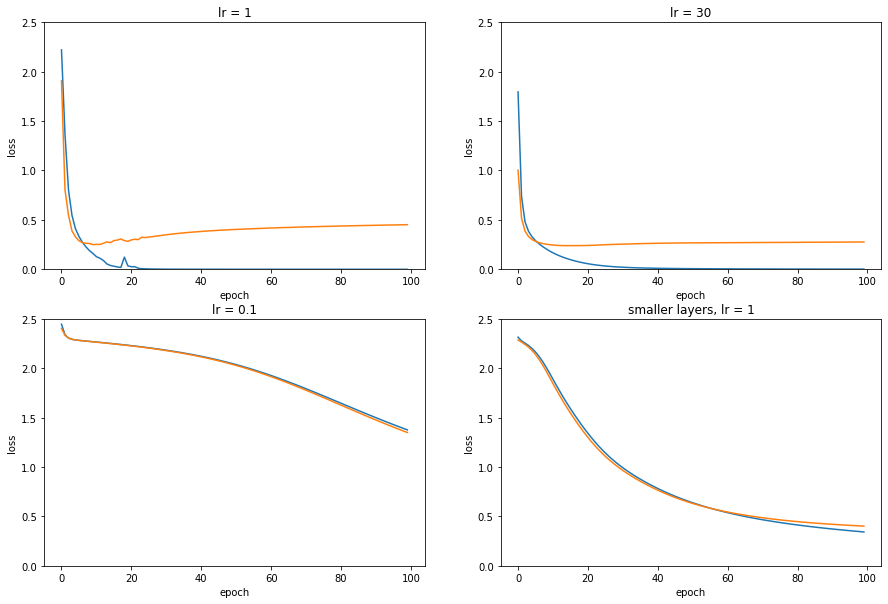

In [221]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# plot the data
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
xdata = list(range(100))

def plot(ax, logs, name):
    epochs = len(logs[0])
    ax.plot(xdata[:epochs], logs[0], color='tab:blue')
    ax.plot(xdata[:epochs], logs[1], color='tab:orange')
    ax.set(xlabel='epoch', ylabel='loss', title=name)
    ax.set_ylim([0, 2.5])
    #ax.set_ylim([1e-1, 2.5])
    #ax.set_yscale('log')

plot(ax1, run1_logs, 'lr = 1')
plot(ax2, run2_logs, 'lr = 30')
plot(ax3, run3_logs, 'lr = 0.1')
plot(ax4, run4_logs, 'smaller layers, lr = 1')

In [222]:
for i, logs in enumerate([run1_logs, run2_logs, run3_logs, run4_logs]):
    print('run', i, 'final validation loss:', logs[1][-1])

run 0 final validation loss: 0.45135638212056867
run 1 final validation loss: 0.27638632911419414
run 2 final validation loss: 1.3485420896769933
run 3 final validation loss: 0.4015081745171882


## 7.4. Testing

In [223]:
m_test = X_test.shape[1]
AL_test, _ = network_forward(X_test, run2_parameters)
correct = (np.argmax(Y_test, axis=0) == np.argmax(AL_test, axis=0)).sum()
   
print('Accuracy on the test images: %d %%' % (100 * correct / m_test))

Accuracy on the test images: 94 %


It should produce 94% accuracy, which is not bad. Notice the learning rate. Change it and play with it. In our simple SGD-based model, it is an important hyperparameter and the performance of our model is learning rate-sensitive. To document your experiments with the hyperparameters, you can also refactor the train and test steps into a function with corresponding parameters, and then call it multiple times.